<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>
</a>
<h1 style="line-height: 1.4;"><font color="#76b900"><b>Building Agentic AI Applications with LLMs</h1>
<h2><b>Tangent 2:</b> Tooling-Enabled LLM Systems</h2>
<br>

**Welcome to our second tangent!**

In the previous notebooks, we highlighted the harsh limitations of our model and hypothesized of ways of squeezing generative capabilities from our system. We were able to approach interesting output requirements that could technically allow an LLM to interface in a consistent way, with a rigid structure, and even with longer-form output artifacts. In this section, we will investigate tooling, which includes featuresets that route, inform, and enable LLMs to do things in an environment. 

### **Learning Objectives:**
**In this notebook, we will:**

- Introduce some LLM orchestration techniques which fall out of our newfound ability to generate structured output.
- Investigate tooling as a concept to see why it is meaningful to define and differentiate for your chosed abstraction.

In [15]:
from langchain_nvidia import ChatNVIDIA

llm = ChatNVIDIA(model="meta/llama-3.1-8b-instruct", base_url="http://llm_client:9000/v1")

<hr><br>

## **Part 1:** Navigating The Controllable Landscape

Now that we know a bit about how we can implement an agent event loop with LangGraph, it's time to put that skill to use! We've already gotten a flavor of agentics from Exercise 3, which on one hand easily falls out of Section 1 but also formalizes a very simple process for agent fulfillment.

- **Put an agent into a conversational loop.**
- **Force them to output in a shema that produces variables.**
- **Based on which variables are produced, modify the control flow accordingly.**

Based on exactly what the control flow is doing, we have different names for what happens:
- When this control flow is used to **select a tool or path**, it's called ***routing***.
- When it is used to **select and parameterize** a tool (presumably to be called), it's called ***tooling***.
- When it is used to **retrieve information**, it's called ***retrieval***.

And the astute among you may notice that there is no concrete difference between these terms; only semantic. Still, it is useful to define these features and consider how you might want to differentiate between them, both in your mind, in code, and in how you communicate your system's efforts and feature-sets.

<img src="images/llm-orchestration.png" style="width:1000px;"/>

<br>

#### **Continued Challenges with LLMs**

Though we can easily perceive how an LLM with human-like skills can interact with arbitrary resources using our set of requirements, we have to remember the quirks associated with LLMs. 
- They are easily derailed and function as a reflection of their training methods, data, input style, and overall capacity.
- They are implemented differently with various assumptions, default support mechanisms, and varying (sometimes dubious) implementations of said support mechanisms. 

This creates an interesting dynamic where, if you want them to collaborate together to solve a non-trivial task, then you need to make some assumptions about our LLMs and their true capabilities.
- Can they call tools? Route to tools? Ask good questions?
- Can they understand the whole environment? What about even the conversation? The last message?
- Should they respond immediately? Plan and execute? Rely on other systems?

Based on your observations, your model pool and budget will strongly dictate whether a truly multi-agent agentic workflow is actually useful. We'll limit our discussion to the Llama-8B model class for this discussion (which you wouldn't think as too good, right?) and will see where we can get with it.

<hr><br>

## **Part 2:** Identifying Some Tools

We've already learned about structured output, so we're already well on our way to implement some kind of routing. However, the actual API you'd like to use will depend on the models you have access to and their intended use-cases. Here are some common configurations which you're likely to find in the wild:

- **Closed-Source LLMs:** Most source-inaccessible LLM providers try to support agentic workflows out-of-the-box despite not necessarily advertising their true model setup. This is why many LLM endpoints no longer support the raw `/completions` endpoint in favor of the standardized `/chat/completions` endpoint.
    - This means that in order to support tooling, you have to follow their Tooling/Structured Output API and hope that it works well. (**OpenAI [Function](https://platform.openai.com/docs/guides/function-calling)/[Assistants](https://platform.openai.com/docs/assistants/tools) API, Claude [Tool Use API](https://docs.anthropic.com/en/docs/build-with-claude/tool-use)**)
    - In practice, this is actually usually very good, and there may be optimizations going on behind the scenes that include automatic prompt injection, server-side rejection, and caching.
- **Open-Source LLMs:** Many open-source efforts aim to standardize and unify the community's API abstractions to help people swap around and find the best models for their purposes. Because of this, the community also creates similar support initiatives and helps to develop tools that compete with private server-hidden options.
    - **On the surface level,** this manifests as support for the most popular APIs, deviating only when it required. For that reason, almost all solutions support the OpenAI API spec for LLMs, VLMs, and embedding models while only some standardization has been made for diffusion, reranking, and document ingestion APIs.
    - **On a deeper level,** the support for such interfaces is a best-effort attempt that can occasionally run counter to model training or stretch the model beyond what it's truly rated and recommended for.

For this reason, we will look at several possible configurations, both from the client-side abstractions that support it as well as hypothetically the server backend that fulfills their end of the bargain.

<br>

### **Part 2.1: Client-Side Tooling**

Frameworks like LangChain provide tooling interfaces for those interested. If you want to integrate a function with your LLM, it would be useful if you didn't have to code up a bunch of boilerplate to make all that work. Below, we can see the langchain way of defining a "tool" using the `@tool` decorator. 

In [16]:
from langchain.tools import tool
from typing import List, Literal

@tool
def calculate(
    thought_process: List[str],
    # tool: Literal["add"],
    # tool: Literal["add", "mult", "pow"],
    tool: Literal["add", "subtract", "multiply", "divide", "power"],
    a: float, 
    b: float
) -> int:
    """Adds a and b. Requires both arguments."""
    if tool == "add": return a + b
    if tool == "subtract": return a - b
    if tool == "multiply": return a * b
    if tool == "divide": return a / b
    if tool == "power": return a ** b

print(calculate.name)
print(calculate.description)
print(calculate.args)
calculate.input_schema.model_json_schema()

calculate
Adds a and b. Requires both arguments.
{'thought_process': {'items': {'type': 'string'}, 'title': 'Thought Process', 'type': 'array'}, 'tool': {'enum': ['add', 'subtract', 'multiply', 'divide', 'power'], 'title': 'Tool', 'type': 'string'}, 'a': {'title': 'A', 'type': 'number'}, 'b': {'title': 'B', 'type': 'number'}}


{'description': 'Adds a and b. Requires both arguments.',
 'properties': {'thought_process': {'items': {'type': 'string'},
   'title': 'Thought Process',
   'type': 'array'},
  'tool': {'enum': ['add', 'subtract', 'multiply', 'divide', 'power'],
   'title': 'Tool',
   'type': 'string'},
  'a': {'title': 'A', 'type': 'number'},
  'b': {'title': 'B', 'type': 'number'}},
 'required': ['thought_process', 'tool', 'a', 'b'],
 'title': 'calculate',
 'type': 'object'}

<br>

As you can see, this is just a thin wrapper around the schema abstraction which allows them to build tools around them. Using much the same tactic as before, we can continue to invoke the tool in a predictable way:

In [17]:
from course_utils import SCHEMA_HINT

sys_msg = (
    "You are a world-class calculator. Please answer the user's question, and use your tools."
    # "Think through your decision in thought-process until you know your first step using order-of-operations. "
    # "Predict the first tool as your last output. Be specific, and then call the tool."
)
# sys_block = []
# sys_block = [("system", sys_msg)]
schema_hint = SCHEMA_HINT.format(schema_hint=calculate.input_schema.model_json_schema())
sys_block = [("system", f"{sys_msg}\n\n{schema_hint}")]

question = "What's 56464 + 4789789097?"
# question = "What's 56464 - 4789789097?"
# question = "What's 56464 / 4789789097?"
# question = "What's 56464 / 4789789097 + 6750 * 478978090?"

calc_llm = llm.with_structured_output(calculate.input_schema)
a = calc_llm.invoke(sys_block + [("user", question)])
print(a)

thought_process=['I will first add 56464 to 4789789097'] tool='add' a=4789789097.0 b=56464.0


In [18]:
calc_tool = llm.with_structured_output(calculate.input_schema) | dict | calculate
calc_tool.invoke(sys_block + [("user", question)])

4789845561.0

In [19]:
llm._client.last_inputs

{'url': 'http://llm_client:9000/v1/chat/completions',
 'headers': {'Accept': 'application/json',
  'Authorization': 'Bearer **********',
  'User-Agent': 'langchain-nvidia-ai-endpoints'},
 'json': {'messages': [{'role': 'system',
    'content': 'You are a world-class calculator. Please answer the user\'s question, and use your tools.\n\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{\'description\': \'Adds a and b. Requires both arguments.\', \'properties\': {\'thought_process\': {\'items\': {\'type\': \'string\'}, \'title\': \'Thought Process\', \'type\': \'array\'}, \'tool\': {\'e

<br>

### **Part 2.2: Server-Side Tool Selection**

In contrast, server-side tool selection is a bit more than a code streamline. Many endpoints that support the structured output interface also try to support an explicit tool-options interface which allows the LLM to select some number of tools to call. The exact mechanisms of this implementation vary, so your endpoint may support any of the following configurations: 
- **Forced Tool-Call**: Explicit grammar enforcement to force a category selection, followed by a generation of the appropriate schema. 
    - **Drawback:** Depending on training and enforcement, this may force an LLM out-of-domain since this may run counter to model training.
    - **Benefit:** This is technically more efficient from the perspective of tokens generated/tokens wasted. It can also be easier to curate fine-tuning data for this type. 
- **Unstructured Output -> Tool Call**: Allow LLM to generate some output (maybe reasoning, maybe casual conversation). This material can be discarded, outputted as the response message body, or integrated otherwise into the structured output. After that, structured output (enforced with guided decoding or otherwise) is aggregated and returned to the user.
    - **Drawback:** More tokens generated, and depending on implementation (either server-side or client-side) the auxiliary tokens might be discarded by default.
    -  **Benefits:** More likely to be in-domain, and might allow for deeper reasoning beyond even the anticipated schema. Furthermore, might allow conversational tool-calling (talk about calling, then issuing the calls, and then terminating the chat naturally).

Below, we can see several tools being defined with preemptive implicit prompt engineering done on the generated docstrings via extra variables, reasonable function names, and attached docstrings. The `search_knowledge` implementation is left out, and will be discussed in the follow-up notebook.

In [20]:
from pydantic import Field
from langchain.tools import tool
from typing import Dict, List, Literal
from ddgs import DDGS
import time
import numpy as np
import sys
import os
os.environ["OTEL_EXPORTER_OTLP_ENDPOINT"] = "http://jaeger:4317"
sys.path.append("/dli/task/composer/microservices")
from ddg_cache import cached_ddg_search, quick_search, search_and_summarize

from contextlib import redirect_stdout

## An example of a tool which could hide an LLM, a database, or merely a query.
## In either case, it can have varying latencies, use various resources,
## and still subscribe to the same surface-level schema.

## Note that this will require you to initiate a database relation:
from ddg_cache import init_database
await init_database()  # <- only needs to be done once

@tool
async def search_internet(user_question: List[str], context: List[str], final_query: str):
    """
    Search the internet for answers. Powered by search engine of choice.
    Create a good search engine (Google or DuckDuckGo) search requests
    """
    ## Very simple method for querying DuckDuckGo
    res = []
    while len(res) == 0: 
        time.sleep(0.1)
        res = DDGS().text(final_query, max_results=10)
    return res

    ## TODO: More involved method which caches results, allows fallbacks, etc.
    # return (await quick_search(final_query, max_results=5))
    
    ## TODO: Even more involved iteration, which also includes multiple stages of summarization
    # return (await search_and_summarize(final_query, max_results=5))

## An example of a fallback tool. If it gets called, it gracefully says to try something else.
## Hopefully this does not break the LLM/chat prompts' prior expectations and the LLM recovers.

@tool
async def search_knowledge(user_question: List[str], context: List[str], final_query: str):
    """Search your knowledge for answers. Includes chat history, common responses, and directives"""
    return "No knowledge ingested. Respond in best-effort based on directive."

## An example of an execution environment. We can coerce a model (especially more powerful ones) to run code
## but this is quite risky without sandboxes. You should probably implement version control, rollbacks, and 
## human-in-the-loop patterns if you're gonna try this (i.e. a domain-specific code generation use-case)

LockedImports = Literal["import numpy as np; import pandas as pd; import math; import print"]

@tool
async def execute_python(user_question: List[str], context: List[str], imports: LockedImports, final_code: str):
    """Execute python code, the values printed through stdout (i.e. `print` will be returned to user)"""
    import contextlib, io
    import numpy as np; import pandas as pd; import math 
    with io.StringIO() as buf, contextlib.redirect_stdout(buf):
        try: 
            exec(final_code, {"numpy": np, "np": np, "pandas": pd, "pd": pd, "math": math})
            return buf.getvalue()
        except Exception as e: 
            return str(e)

## A very simple but very useful tool. Random number generation should never be done with an LLM, 
## but "selecting" a random number tool could be a way to bypass this. Can be done to randomize 
## LLM's environment for game logic, synthetic data sampling, etc.

@tool
def random_choice(options: List[str], num_samples: int, probs: List[float]):
    """Returns a random option generated from the p distributions (list of floats)"""
    return np.random.choice(options, num_samples, probs)

schema = search_internet
# schema = search_knowledge
# schema = execute_python
print(schema.name)
print(schema.description)
print(schema.args)
schema.input_schema.model_json_schema()

search_internet
Search the internet for answers. Powered by search engine of choice.
Create a good search engine (Google or DuckDuckGo) search requests
{'user_question': {'items': {'type': 'string'}, 'title': 'User Question', 'type': 'array'}, 'context': {'items': {'type': 'string'}, 'title': 'Context', 'type': 'array'}, 'final_query': {'title': 'Final Query', 'type': 'string'}}


{'description': 'Search the internet for answers. Powered by search engine of choice.\nCreate a good search engine (Google or DuckDuckGo) search requests',
 'properties': {'user_question': {'items': {'type': 'string'},
   'title': 'User Question',
   'type': 'array'},
  'context': {'items': {'type': 'string'},
   'title': 'Context',
   'type': 'array'},
  'final_query': {'title': 'Final Query', 'type': 'string'}},
 'required': ['user_question', 'context', 'final_query'],
 'title': 'search_internet',
 'type': 'object'}

<br>

Lucky for us, our Llama NIM directly supports this tool calling on its own (and we'll let you guess which strategy is used based on latency). Since that LangChain connector streamlines tool binding with `bind_tools`, we can use it like `with_structured_output` and then just add some schema hints to our prompts to make this all work. 
- **Reminder:** In LangChain, `bind` merely binds an argument to the runnable/client. `bind_tools`, like `with_structured_output`, is just a flavor that also processes the schema into a server-expected form.

In [26]:
from course_utils import SCHEMA_HINT

toolbank = [search_internet, search_knowledge, calculate, execute_python, random_choice]
# toolbank = [search_internet, search_knowledge, calculate, execute_python]
# toolbank = [search_internet, search_knowledge, calculate]
# toolbank = [search_internet, search_knowledge]
tooldict = {tool.name: tool for tool in toolbank}
tool_arg_generator = llm.bind_tools(toolbank) | dict

query = (
    # "Can you please calculate the first 20 digits of pi?"
    # "Can you please calculate the first 20 digits of pi? Make sure to use the execute_python tool."
    # "Can you please pick a random color for me?"
    # "Can you please pick a random color for me with uniform probability?"
    # "Can you please tell me about NVIDIA's new DIGITS systems?"
    # "Can you please tell me about NVIDIA's new DIGITS systems? What do you know from your knowledge?"
    # "Can you please tell me about NVIDIA's NeMo NAT system? Think about it"
    "What's the new LangGraph middleware abstraction, and why is it useful?"
)

output = tool_arg_generator.invoke([
    ("system", (
        "You are an NVIDIA Chatbot. Please help the user with their concerns.\n"
        + SCHEMA_HINT.format(schema_hint="\n".join(str(tool.input_schema.model_json_schema()) for tool in toolbank))
    )), ("user", query),
])
# print(output)
print("Content:", output.get('content') or "Blank")
print("Tool Calls:")
output.get('tool_calls', [])

Content: Blank
Tool Calls:


[{'name': 'search_internet',
  'args': {'user_question': ['New LangGraph middleware abstraction'],
   'context': [],
   'final_query': 'New LangGraph middleware abstraction LangGraph'},
  'id': 'chatcmpl-tool-3ff73d0a176346418edcecf7971bdf37',
  'type': 'tool_call'}]

In [8]:
## Feel free to try some of these prompts out to see what works and what doesn't. 
## When you're ready to see if it would have worked in calling the tool, you can run the cell below:

for tool_call in output.get('tool_calls', []):
    print("Tool Input:", tool_call)
    tool_response = await tooldict[tool_call.get("name")].ainvoke(input=tool_call.get("args"))

2025-10-27 17:23:08,203 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200


Tool Input: {'name': 'search_internet', 'args': {'user_question': ['langgraph', 'middleware', 'abstraction'], 'context': [], 'final_query': 'what is langgraph middleware?'}, 'id': 'chatcmpl-tool-ce637de2dcde4d9ea85031cefab8505c', 'type': 'tool_call'}


2025-10-27 17:23:09,055 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:09,261 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:09,559 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:10,282 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:10,508 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:10,749 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:10,955 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:11,188 - INFO - primp - response: https://www.bing.com/search?q=what+is+langgraph+middleware%3F 200
2025-10-27 17:23:11,425 - INFO - primp - response: https://www.b

In [22]:
from IPython.display import display

if "query" in tool_response:
    display(tool_response["query"])
    display(tool_response["summary"])
    display([result["href"] for result in tool_response.get("results")])
else:
    display(tool_response)

[{'title': 'langgraph/docs/docs/how-tos/http/custom_middleware.md at …',
  'href': 'https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/http/custom_middleware.md',
  'body': "Adding middleware lets you intercept and modify requests and responses globally across your deployment, whether they're hitting your …"},
 {'title': 'How to add custom middleware - Docs by LangChain',
  'href': 'https://docs.langchain.com/langsmith/custom-middleware',
  'body': 'Adding middleware lets you intercept and modify requests and responses globally across your deployment, whether they’re hitting your …'},
 {'title': 'What is LangGraph? - GeeksforGeeks',
  'href': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
  'body': 'Oct 10, 2025 · At its core, LangGraph combines large language models (LLMs) with graph-based architectures allowing developers to map, …'},
 {'title': "What is LangGraph: Beginner's Guide | K21Academy",
  'href': 'https://k21academy.com/ai-ml/langgra

<br>

And there is our tool use in action. From this little example, you'll notice it's not perfect and requires prompt engineering like all other things:
- If the function names aren't descriptive enough, it may default to something more ubiquitous-sounding like "calculate" even if the actual features implemented are insufficient.
- The Python running tool is actually very finicky to implement for lighter-weight models, and you can see that we hacked it to be at least stable enough for this simple invocation by adding hints for libraries to use.
- Even unintentional phrasing mismatches can cause incorrect tool usage if your system isn't properly converting instructions into some canonical form.

Still, it does at least appear that we can call tools with our LLM and even select them to some extent, which is pretty cool! 

Notice how the shift from `with_structured_output` to `bind_tools` merely shifts the obligation of tool selection from the client to the server. As we said, this isn't a superficial shift and actually underscores some pros and cons. While `bind_tools` makes the whole thing easier for the caller, it also takes away control which might be necessary to perform some key functionalities. It's important to consider that in your implementations and choose the correct strategy as you move from one model to another, as the server-side assumptions may or may be optimal for any particular use-case.




<hr><br>

## **Part 3:** Using Tools In A Loop (ReAct)

Now that we've defined some simple tools to interface with some environment, we can equip our LLM with them and maybe hope for a multi-turn conversation. In fact, maybe even a multi-step conversation where they use multiple tools and get back to us when they actually have their answer.

> <img src="images/react-opts.png" style="width: 1000px" />
>
> <a href="https://react-lm.github.io/" target="_blank"><b>ReAct: Synergizing Reasoning and Acting in Language Models (2022)</b></a>
>

To do this, it turns out there are some pretty simple ways to approach the problem which all come with some failure modes but seem to scale nicely in performance as models continue to improve. We'll explore just a few of them in this notebook, but rest assured that these are only the most popular ones among many potential options:

### **Original ReAct:** 

Short for ***Reason and Act***, ReAct is a storied technique which gained quick popularity in the LLM orchestration space and quickly grew well beyond its original definition as frameworks continued to evolve. ReAct was originally proposed as a strategy for maintaining an **agent scratchpad** in which the LLM would be given a directive, some examples of tool calls, and some examples of fulfillments. Based on that, the context would grow as these `{questions,answers,fulfillment}` examples would pile up in the window. This is in contrast to just `{question,fulfillment}`, as the answer would give some reasoning behind the decision first. 

For example, the following would be a reasonable prompt directive that would be included by default:

In [25]:
from langchain import hub

prompt = hub.pull("hwchase17/react")
print(prompt.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


/usr/local/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


<br>

And the result of using this kind of prompt by default would be... well... here's a direct example from [the legacy documentation](https://python.langchain.com/v0.1/docs/modules/agents/agent_types/react/) as applied to the 8B 3.1 model:

In [24]:
import langchain.agents as lc_agents
from IPython.display import display
from langchain_nvidia import NVIDIA
# NVIDIA.get_available_models()

base_llm = NVIDIA(
    model="bigcode/starcoder2-7b", 
    base_url="http://llm_client:9000/v1", 
)

lc_agent_llm = base_llm

# Construct the ReAct agent
agent = lc_agents.create_react_agent(lc_agent_llm, toolbank, prompt)
agent_executor = lc_agents.AgentExecutor(agent=agent, tools=toolbank, verbose=True, handle_parsing_errors=True)

try:
    agent_executor.invoke(
        {
            "input": "what's my name? Only use a tool if needed, otherwise respond with Final Answer",
            # Notice that chat_history is a string, since this prompt is aimed at LLMs, not chat models
            "chat_history": "Human: Hi! My name is Bob\nAI: Hello Bob! Nice to meet you",
        },
        verbose=True
    )
except Exception as e:
    print("Exception:", e)
    print("\nInput:") or display(lc_agent_llm._client.last_inputs)
    print("\nOutput:") or display(getattr(lc_agent_llm._client.last_response, "json", lambda: None)(), None)



> Entering new AgentExecutor chain...
 Find a tool that can find my name
Action: search_internet
ActionInvalid Format: Missing 'Action Input:' after 'Action:' I can't find my name, so I'll come up with my own nameInvalid Format: Missing 'Action:' after 'Thought:' Now I have a name, I can use it with a software package that canInvalid Format: Missing 'Action:' after 'Thought:' No software package can find my name, so I must find tools that
ObservationInvalid Format: Missing 'Action:' after 'Thought:' If I have to find tools that can find my name, find them using
Invalid Format: Missing 'Action:' after 'Thought:' After searching for tools that can find my name, see that type of
ObservationInvalid Format: Missing 'Action:' after 'Thought:' With this knowledge, I can now use a tool
ObservationInvalid Format: Missing 'Action:' after 'Thought:' Searching for a tool that can find my name only gave programs
ObservationInvalid Format: Missing 'Action:' after 'Thought:' Finding the tool that c

<br>

As you can see, the workflows for this format are mostly deprecated in modern language models, but it was a good start and pioneered many interesting examples when unguided autoregression was the main technique. Good examples would reinforce in-context tool calling, bad examples would cause complaints to be logged back to the LLM, and token stop conditions would ensure that the LLM wouldn't try to answer its own questions that it queued up.

### **Modern-Day ReAct:**

Since the idea of ReAct is so closely tied to the agent abstraction, it more or less grew legs as a general idea of "think about it, interact, see what happens, repeat." This combined with the emergence of tool selection/structured output evolved the term to encompass any agentic system that:

- **Has a central dialog loop.**
- **Can call tools at its disposal.**
- **Can respond to the user directly.**

In other words, **a ReAct agent is now just any agent with a running conversation buffer that can call a set of tools that include the user.** You're free to debate whether or not this is a sound evolution of the phrase, but it is catchy and intuitive enough and the term has since stuck.

We can try this new flavor of the ReAct loop in its default import form from the `langgraph` library, and we'll see a different set of results from its invocation:

In [28]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.history import RunnableWithMessageHistory

checkpointer = MemorySaver()
langgraph_agent_executor = create_react_agent(llm, toolbank, checkpointer=checkpointer)

query = (
    # "Can you please calculate the first 20 digits of pi?"
    # "Can you please calculate the first 20 digits of pi? Make sure to use the execute_python tool."
    # "Can you please pick a random color for me?"
    # "Can you please pick a random color for me with uniform probability?"
    # "Can you please tell me about NVIDIA's new DIGITS systems?"
    "Can you please tell me about NVIDIA's new DIGITS systems? What do you know from your knowledge?"
)

config = {"configurable": {"session_id": "test-session", "thread_id": "test-thread"}}

messages = langgraph_agent_executor.invoke({"messages": [("human", query)]}, config=config)
{"input": query, "output": messages["messages"][-1].content}

{'input': "Can you please tell me about NVIDIA's new DIGITS systems? What do you know from your knowledge?",
 'output': 'Unfortunately, I was unable to find any information about DIGITS System.'}

We can try to check out the history and see that... it seems to be performing like expected:

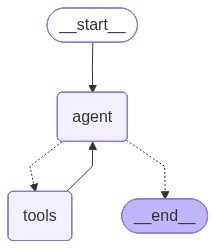

In [31]:
langgraph_agent_executor

<br>

That's because this version strongly assumes the ability to call tools through the tool-use API, and merely enforces the now-coined "ReAct Loop" as its main control flow:

In [30]:
langgraph_agent_executor.get_state(config).values

{'messages': [HumanMessage(content="Can you please tell me about NVIDIA's new DIGITS systems? What do you know from your knowledge?", additional_kwargs={}, response_metadata={}, id='25df8b20-26d2-4690-a4b6-bc31157600c7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-3e18e44c01c74c1a89bcc7e321d62601', 'type': 'function', 'function': {'name': 'search_knowledge', 'arguments': '{"user_question": ["NVIDIA DIGITS"], "context": [], "final_query": "What is NVIDIA DIGITS?"}'}}]}, response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'chatcmpl-tool-3e18e44c01c74c1a89bcc7e321d62601', 'type': 'function', 'function': {'name': 'search_knowledge', 'arguments': '{"user_question": ["NVIDIA DIGITS"], "context": [], "final_query": "What is NVIDIA DIGITS?"}'}}], 'token_usage': {'prompt_tokens': 913, 'total_tokens': 944, 'completion_tokens': 31}, 'finish_reason': 'tool_calls', 'model_name': 'meta/llama-3.1-8b-instruct'}, id='run--892b4919-21f0-4f0

<br>

We'll talk more about langgraph later, but you can try to run the executor once again to see what would happen if you wanted to ask a follow-up question:

In [32]:
messages = langgraph_agent_executor.invoke({"messages": [("human", "Can you now see what happens when you use another tool?")]}, config=config)
messages["messages"][-1].content

'I was unable to find any information about what happens when you use another tool besides NVIDIA DIGITS, or for alternatives for NVIDIA DIGITS'

In [33]:
langgraph_agent_executor.get_state(config).values

{'messages': [HumanMessage(content="Can you please tell me about NVIDIA's new DIGITS systems? What do you know from your knowledge?", additional_kwargs={}, response_metadata={}, id='25df8b20-26d2-4690-a4b6-bc31157600c7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-3e18e44c01c74c1a89bcc7e321d62601', 'type': 'function', 'function': {'name': 'search_knowledge', 'arguments': '{"user_question": ["NVIDIA DIGITS"], "context": [], "final_query": "What is NVIDIA DIGITS?"}'}}]}, response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'chatcmpl-tool-3e18e44c01c74c1a89bcc7e321d62601', 'type': 'function', 'function': {'name': 'search_knowledge', 'arguments': '{"user_question": ["NVIDIA DIGITS"], "context": [], "final_query": "What is NVIDIA DIGITS?"}'}}], 'token_usage': {'prompt_tokens': 913, 'total_tokens': 944, 'completion_tokens': 31}, 'finish_reason': 'tool_calls', 'model_name': 'meta/llama-3.1-8b-instruct'}, id='run--892b4919-21f0-4f0

<hr><br>

## **Part 4:** Server-Siding Tool Execution

By now we have examples of client-side tool selection and have just introduced server-side tool selection. In both cases, the endpoint is only responsible for the semantic part of the problem while the actual fulfillment remains a client-side burden. This isn't always the case, and there are some valid use-cases for server-side tooling and even automatic tooling support.

> <img src="images/tooling-patterns.png" style="width:1000px;"/>

#### **Wrapper Application/Agent:** 

Obviously you can create a wrapper application around an LLM with its own tooling assumptions and fulfillment strategies. Many such systems will be interfaced in much the same way as an LLM server (i.e. you stream or invoke the API), but will be calling plenty of tools, managing its own state, etc. This shouldn't be surprising, and is just a trivial inclusion of the microservice design pattern.

**Examples:** 
- A **retrieval microservice** may support the completion streaming API and may very well have structured output as an internal component, even if its main job is to interface with some knowledge base.
- A **chatbot persona** could be reduced to a high-level API which automatically honors state and picks from its set of pre-defined tools while maintaining a system prompt. If it's isolated to a server, its runtime could be moved to an arbitrary compute source and we could define arbitrary resource ownership/scaling rules.

#### **Test-Time Compute/Inference-Time Scaling:** 

There may be times where tooling, routing, or branching strategies are tightly interwoven with training or otherwise boost the performance of the model merely by being enforced in the background. In this case, you may see phrases like *"Test-Time Compute"* and *"Interence-Time Scaling"* getting thrown around without much definition (maybe described as "thinking"). These are vague terms with evolving meanings, and are technically synonymous: 
- **Test-Time** and **Inference-Time** merely mean that they are happening after the model has already been trained, and usually when it is actually running in the wild.
- **Compute** and **Scaling** (or *compute scaling*) suggests that there is extra compute being put into the decisions and output creation of the model, with potential emphasis on a substantial increase in processing effort.

The critical among you may notice that this *sounds* like an agentic workflow or an LLM pipeline... but now it gets sanctioned as an LLM inference feature? Technically speaking, there is usually an added implication that the model is trained to support this extra process OR through a lot of synthetic data OR a complementary extra model is also integrated into the loop that was specially-designed for this process, *but it's technically not a requirement*. 

**Examples:**
- **"Scaling-Adjacent:** A reasoning system that output chain-of-thought could have its output auto-expanded such that each process is either **performed in parallel (*branched*)**, **executed sequentially (*iterated*)**, or **combined together (*merged*)**. This may explode the inference time required for the processes, but may be considered a baked-in feature of the model since it's explicitly trained for this format.
- **"Compute-Adjacent:** This category is quite broad and could encompass almost any LLM orchestration efforts that make their way into an inference server. As an example, a model may be **evaluated and judged by some classifier or reward model** to better align the response as the output gets generated. This can be used to either make the inference heavier or lighter.
    - For the lighter option, techniques like **speculative decoding** (autoregressing a chunk of values at a time with a ligher-weight model until a token of high uncertainty is hit) and **dynamic guardrails** (pre-trained or progressively-trained embedding models used for classification) can be used to speed up inference.
    - For heavier options, using a **reward model to critique and guide** the generation generally leads to a severe slowdown but can be useful for critical scenarios. This is sometimes used for inference but is more common for training i.e. reinforcement learning.

The thing to remember with these 

#### **Tool Registration:** 

For scenarios that leverage complex workflows like branching while limiting access to the underlying model, parallelized tool calls can be quite challenging to fulfill through a network interface. For this reason, some more advanced workflows may limit the toolset to a finite list of pre-implemented options.

To offer more customization, one potential work-around is to have the client host their own tools via thread-safe endpoints (i.e. scalable/restrictive async methods) and allow them to register the tools as callable via the provided schema. Assuming this endpoint is accessible via a port interface, then the server can asynchronously call the hosted endpoints for fulfillment. This approach is noticeable in the [**Anthropic Model Context Protocol**](https://www.anthropic.com/news/model-context-protocol), and is technically just a microservice-style abstraction where an increasingly-marginalized closed-source server is interacting with a larger ecosystem of functions.

<hr><br>

### **Part 5:** Reflecting On This Exercise

You may notice that we didn't exactly paint "tooling" as a concrete abstraction. We've more-or-less just combined the following two statements to their logical conclusion:

> **"An LLM can make statements and decision" + "An LLM can be forced to output in a structure that can be interpretted by another system" = "You can use the outputs of an LLM system to interact with another system"**

And then we concluded that you can also modularize, offload, or auto-handle this at various levels of abstraction. This is fundamental and useful, and is how you can skip the user entirely, integrate them selectively, or force an overbearing dependency that's even more extreme that the basic user + LLM agent loop. It also doesn't even scratch the surface of ways in which you can route a system to define its own control flow:
- You can fine-tune a model or use an embedding model to help move around the control space.
- You can have a pool of expert systems which vote on the best routes to go, or try to express their reason and "certainty" in a particular direction.
- You can have random decisions and algorithmic conditional logic, which can be interesting its own right and should feel obvious.

But again, this is just all a logical extension from previous abstractions, and depend heavily on the qualities of the LLM and your willingness to work around them.

<br>
<a href="https://www.nvidia.com/en-us/training/">
    <div style="width: 55%; background-color: white; margin-top: 50px;">
    <img src="https://dli-lms.s3.amazonaws.com/assets/general/nvidia-logo.png"
         width="400"
         height="186"
         style="margin: 0px -25px -5px; width: 300px"/>